## Постановка задачи

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Пути к директориям и файлам**

In [114]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'
PREP_DATASET_PATH = './SSolovev_predictions.csv'

SCALER_FILE_PATH = './scaler.pkl'

TRAIN_FULL_PATH = './training_project_train_full.csv'
TRAIN_PART_PATH = './training_project_train_part_b.csv'
TEST_PART_PATH = './training_project_test_part.csv'

### Загрузка данных

In [3]:
# Тренировочный датасет
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
# Сравним тренировочный датасет с тестовым
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [5]:
df_train.shape

(7500, 17)

In [6]:
df_test.shape

(2500, 16)

In [7]:
# Посмотрим общую информацию.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

Данные совпадают. Пропуски одни и те же.

### Обработка пропусков и выбросов

In [9]:
# Имеются пропуски. Исследуем их

In [10]:
# Annual Income
print('Наименьшее: ', df_train['Annual Income'].min())
print('Наибольшее: ', df_train['Annual Income'].max())
print('Медиана: ', df_train['Annual Income'].median())
print('Среднее: ', df_train['Annual Income'].mean())
print('Мода: ', df_train['Annual Income'].mode()[0])

Наименьшее:  164597.0
Наибольшее:  10149344.0
Медиана:  1168386.0
Среднее:  1366391.7201749957
Мода:  969475.0


In [11]:
# На первый взгляд в Annual Income нет выбросов. Мы не можем с достаточной уверенностью заявлять,
# что какой то доход не реальный. Для замены пропусков в доходе, на мой взгляд болше подойдет
# медиана.

In [12]:
# Заменим пропуски на медиану
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train['Annual Income'].median()

In [13]:
# Сменим тип данных
df_train['Annual Income'] = df_train['Annual Income'].astype(int)

In [14]:
# Months since last delinquent
print('Наименьшее: ', df_train['Months since last delinquent'].min())
print('Наибольшее: ', df_train['Months since last delinquent'].max())
print('Медиана: ', df_train['Months since last delinquent'].median())
print('Среднее: ', df_train['Months since last delinquent'].mean())
print('Мода: ', df_train['Months since last delinquent'].mode()[0])

Наименьшее:  0.0
Наибольшее:  118.0
Медиана:  32.0
Среднее:  34.69260017548991
Мода:  14.0


In [15]:
# Здесь так же сложно утверждать, что какое либо значение является выбросом. Пропуски целесообразнее заменить
# наиболее часто встречающимся значением. Вероятность такого события наибольшая.

In [16]:
# Заменим пропуски на moda
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_train['Months since last delinquent'].mode()[0]

In [17]:
# Сменим тип данных
df_train['Months since last delinquent'] = df_train['Months since last delinquent'].astype(int)

In [18]:
# Credit Score
print('Наименьшее: ', df_train['Credit Score'].min())
print('Наибольшее: ', df_train['Credit Score'].max())
print('Медиана: ', df_train['Credit Score'].median())
print('Среднее: ', df_train['Credit Score'].mean())
print('Мода: ', df_train['Credit Score'].mode()[0])

Наименьшее:  585.0
Наибольшее:  7510.0
Медиана:  731.0
Среднее:  1151.0874978966851
Мода:  740.0


In [19]:
# Скорее всего в данных имеются выбросы. Сделаем предположение, что кредитный рейтинг должен быть
# трехзначным. Разделим четырехзначные значения на 10.

In [20]:
df_train.loc[df_train['Credit Score'] / 1000 > 1, 'Credit Score'] = df_train['Credit Score'] / 10

In [21]:
x = df_train['Credit Score'].value_counts()
x

740.0    184
747.0    172
748.0    163
741.0    155
745.0    155
        ... 
609.0      1
598.0      1
641.0      1
589.0      1
620.0      1
Name: Credit Score, Length: 160, dtype: int64

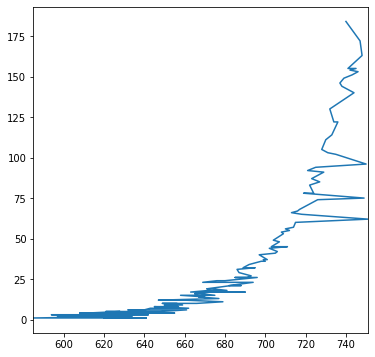

In [22]:
# Посмотрим на графике зависимость кредитного рейтинга от количества человек
from pylab import rcParams
rcParams['figure.figsize'] = 6, 6
x.plot()
plt.show()

In [23]:
# Можно заметить, что явного преобладания какого либо рейтинга нет. Можно предположить, что люди без рейтинга
# не брали кредит и не имеют рейтинга. При отсутствии рейтинга у трети заемщиков, использование этого показателя
# вызывает сомнения. Пока заменим пустые значения 0.

In [24]:
# Заменим пропуски на 0
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = 0

In [25]:
# Сменим тип данных
df_train['Credit Score'] = df_train['Credit Score'].astype(int)

In [26]:
df_train['Credit Score'].value_counts()

0      1557
740     184
747     172
748     163
745     155
       ... 
630       1
631       1
619       1
607       1
586       1
Name: Credit Score, Length: 161, dtype: int64

In [27]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [28]:
# Заменим пропуски на moda
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]

In [29]:
# Сменим тип данных
df_train['Bankruptcies'] = df_train['Bankruptcies'].astype(int)

In [30]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [31]:
def replacement(df):    
    df.loc[df['Years in current job'] == '10+ years', 'Years in current job'] = 10
    df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = 0
    df.loc[df['Years in current job'] == '1 year', 'Years in current job'] = 1
    # Заменим пропуски на 10, как наиболее часто встречающееся
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = 10
    for n in range(2, 10):
        df.loc[df['Years in current job'] == str(n)+' years', 'Years in current job'] = n  

In [32]:
replacement(df_train)

In [33]:
df_train['Years in current job'].value_counts()

10    2703
2      705
3      620
0      563
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: Years in current job, dtype: int64

**Обзор номинативных признаков**

In [34]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
****************************************************************************************************



In [35]:
# Объединим все значения, кроме debt consolidation  в other
df_train.loc[df_train['Purpose'] != 'debt consolidation', 'Purpose'] = 'other'

In [36]:
df_train['Purpose'].value_counts()

debt consolidation    5944
other                 1556
Name: Purpose, dtype: int64

### Приведение типов

In [37]:
# Переведем float в int
for colname in ['Number of Open Accounts', 'Number of Credit Problems', 'Years of Credit History',
                'Tax Liens', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance',
               'Monthly Debt']:
    df_train[colname] = df_train[colname].astype(int)

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null int64
Years in current job            7500 non-null int64
Tax Liens                       7500 non-null int64
Number of Open Accounts         7500 non-null int64
Years of Credit History         7500 non-null int64
Maximum Open Credit             7500 non-null int64
Number of Credit Problems       7500 non-null int64
Months since last delinquent    7500 non-null int64
Bankruptcies                    7500 non-null int64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null int64
Current Credit Balance          7500 non-null int64
Monthly Debt                    7500 non-null int64
Credit Score                    7500 non-null int64
Credit Default                  7500 non-null int64
dtypes

In [39]:
# Заменим Long Term на 1 и Short Term на 0 и тип на int
df_train['Term'] = (df_train['Term'] == 'Long Term').astype(int)
df_train['Term'].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

In [40]:
# Заменим debt consolidation на 1 и other на 0 и тип на int
df_train['Purpose'] = (df_train['Purpose'] == 'debt consolidation').astype(int)
df_train['Purpose'].value_counts()

1    5944
0    1556
Name: Purpose, dtype: int64

### Построение новых признаков

**Id**

In [41]:
df_train['ID'] = df_train.index.tolist()

**Dummies**

In [42]:
for cat_colname in df_train.select_dtypes(include='object').columns[:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

**Обзор количественных признаков**

In [43]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,...,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.325286e+06,6.084133,0.030133,11.130933,17.889333,9.451537e+05,0.170000,23.433067,0.116933,0.792533,...,1.187318e+07,2.898332e+05,18314.454133,570.596933,0.281733,3749.500000,0.001600,0.484933,0.086267,0.427200
std,7.567551e+05,3.640717,0.271604,4.908924,7.050672,1.602622e+07,0.498598,17.906245,0.346904,0.405520,...,3.192612e+07,3.178714e+05,11926.764673,293.136944,0.449874,2165.207842,0.039971,0.499806,0.280776,0.494705
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,1.124200e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.311330e+05,3.000000,0.000000,8.000000,13.000000,2.792295e+05,0.000000,14.000000,0.000000,1.000000,...,1.801690e+05,1.142565e+05,10067.500000,664.000000,0.000000,1874.750000,0.000000,0.000000,0.000000,0.000000
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,14.000000,0.000000,1.000000,...,3.095730e+05,2.093230e+05,16076.500000,720.000000,0.000000,3749.500000,0.000000,0.000000,0.000000,0.000000
75%,1.499974e+06,10.000000,0.000000,14.000000,21.000000,7.935015e+05,0.000000,29.000000,0.000000,1.000000,...,5.198820e+05,3.604062e+05,23818.000000,738.000000,1.000000,5624.250000,0.000000,1.000000,0.000000,1.000000
max,1.014934e+07,10.000000,7.000000,43.000000,57.000000,1.304726e+09,7.000000,118.000000,4.000000,1.000000,...,1.000000e+08,6.506797e+06,136679.000000,751.000000,1.000000,7499.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 22 columns):
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null int64
Years in current job            7500 non-null int64
Tax Liens                       7500 non-null int64
Number of Open Accounts         7500 non-null int64
Years of Credit History         7500 non-null int64
Maximum Open Credit             7500 non-null int64
Number of Credit Problems       7500 non-null int64
Months since last delinquent    7500 non-null int64
Bankruptcies                    7500 non-null int64
Purpose                         7500 non-null int64
Term                            7500 non-null int64
Current Loan Amount             7500 non-null int64
Current Credit Balance          7500 non-null int64
Monthly Debt                    7500 non-null int64
Credit Score                    7500 non-null int64
Credit Default                  7500 non-null int64
ID      

**Сохраним полученный датасет**

In [45]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

### Анализ данных

**Выделение целевой переменной и групп признаков**

In [72]:
df_base = pd.read_csv(TRAIN_DATASET_PATH)
df_train = pd.read_csv(PREP_DATASET_PATH)

df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent
0,Own Home,482087,10,0,11,26,685960,1,14,1,...,99999999,47386,7914,749,0,0,0,0,1,0
1,Own Home,1025487,10,0,15,15,1181730,0,14,0,...,264968,394972,18373,737,1,1,0,0,1,0
2,Home Mortgage,751412,8,0,11,35,1182434,0,14,0,...,99999999,308389,13651,742,0,2,0,1,0,0
3,Own Home,805068,6,0,8,22,147400,1,14,1,...,121396,95855,11338,694,0,3,0,0,1,0
4,Rent,776264,8,0,13,13,385836,1,14,0,...,125840,93309,7180,719,0,4,0,0,0,1


In [73]:
df_base.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [74]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [75]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [76]:
NEW_FEATURE_NAMES

Index(['ID', 'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent'],
      dtype='object')

**Обзор целевой переменной**

In [51]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

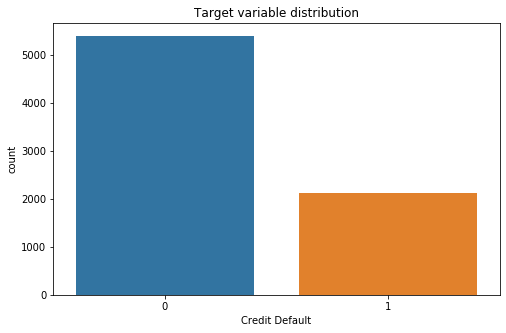

In [52]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

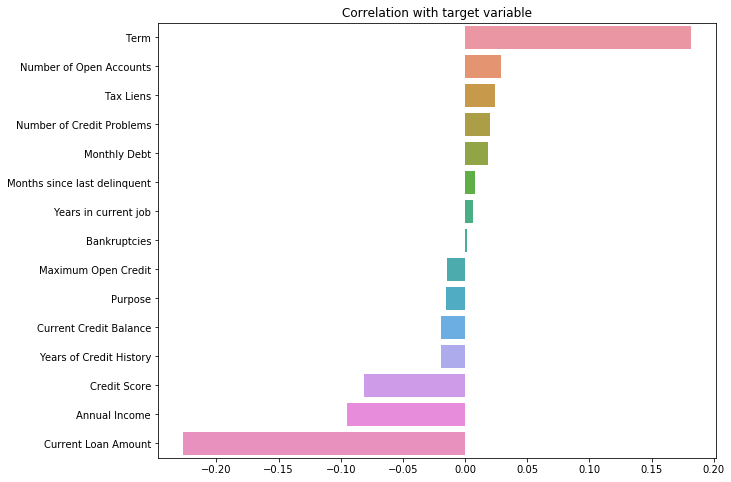

In [53]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Корреляция с новыми признаками**

In [54]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 22 columns):
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null int64
Years in current job            7500 non-null int64
Tax Liens                       7500 non-null int64
Number of Open Accounts         7500 non-null int64
Years of Credit History         7500 non-null int64
Maximum Open Credit             7500 non-null int64
Number of Credit Problems       7500 non-null int64
Months since last delinquent    7500 non-null int64
Bankruptcies                    7500 non-null int64
Purpose                         7500 non-null int64
Term                            7500 non-null int64
Current Loan Amount             7500 non-null int64
Current Credit Balance          7500 non-null int64
Monthly Debt                    7500 non-null int64
Credit Score                    7500 non-null int64
Credit Default                  7500 non-null int64
ID      

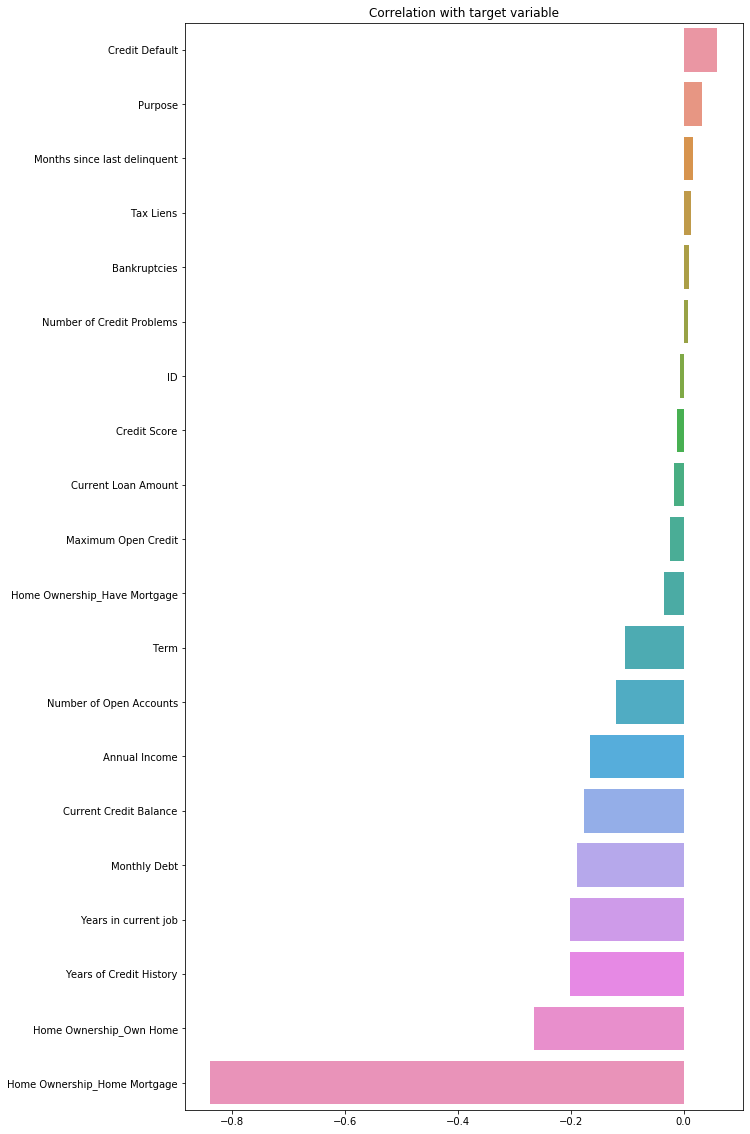

In [55]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Оценка признака "Current Loan Amount" в разрезе целевой переменной**

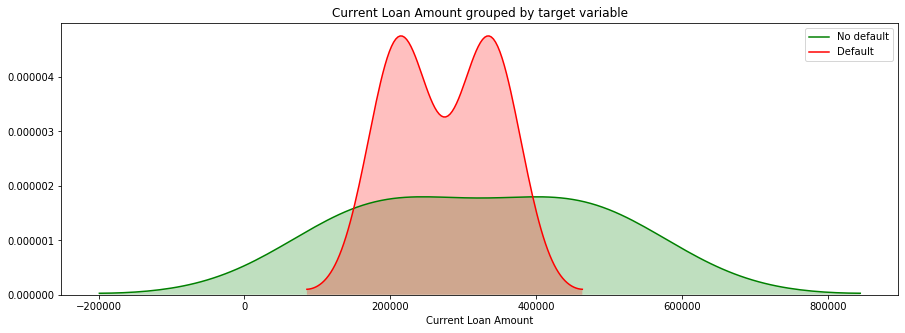

In [56]:
limit_bal_with_target_s = df_train[['Current Loan Amount', TARGET_NAME]].sample(6)
limit_bal_s = limit_bal_with_target_s['Current Loan Amount']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(15, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Current Loan Amount" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Current Loan Amount" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Чтобы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

In [57]:
# Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка
from scipy.stats import shapiro
shapiro(limit_bal_s)

(0.8456488847732544, 0.14509303867816925)

P-value = 0.14 То есть, можно утверждать, что распределение нормальное с вероятностью 44%, что существенно выше заданного критерия 5%. И выборки скорее всего имеют одинаковое распределение.

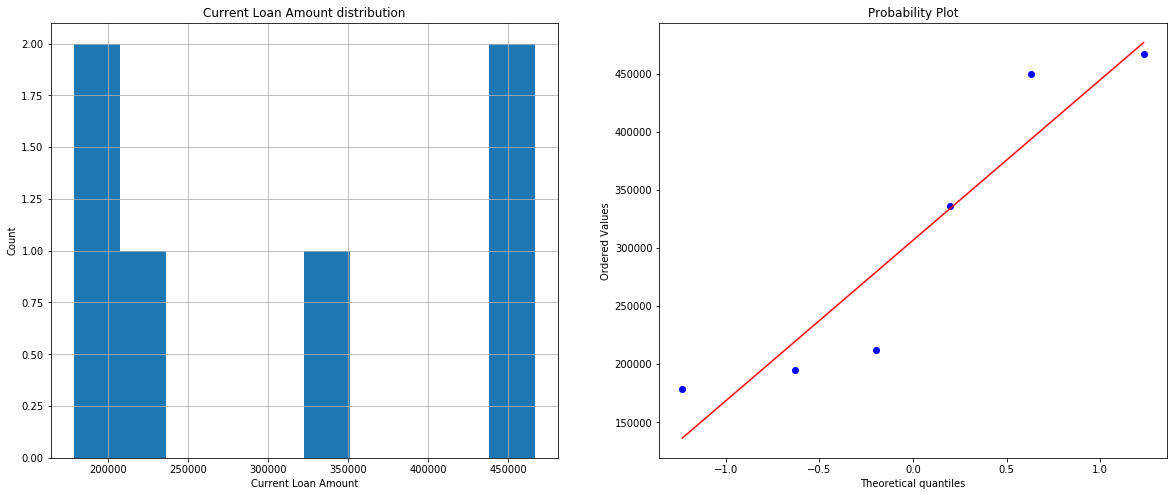

In [58]:
# Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

from scipy.stats import probplot

plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

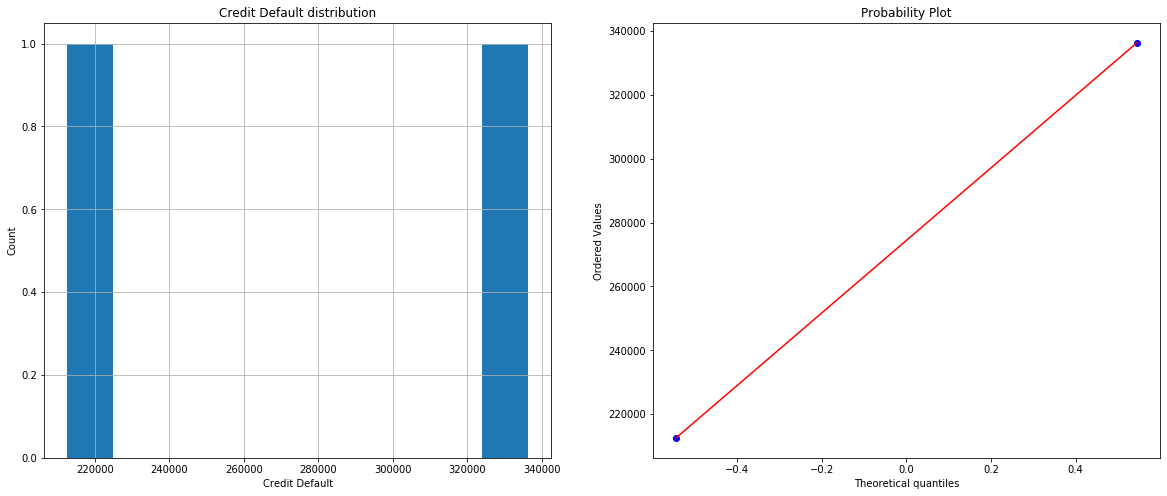

In [59]:
from scipy.stats import probplot

plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Default')
ax1.set_ylabel('Count')
ax1.set_title('Credit Default distribution')
limit_bal_target_1.hist()

plt.subplot(122)
probplot(limit_bal_target_1, dist='norm', plot=plt)

plt.show()

In [60]:
# Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

from scipy.stats import mannwhitneyu

mannwhitneyu(limit_bal_target_0, limit_bal_target_1)

MannwhitneyuResult(statistic=4.0, pvalue=0.40848066085769563)

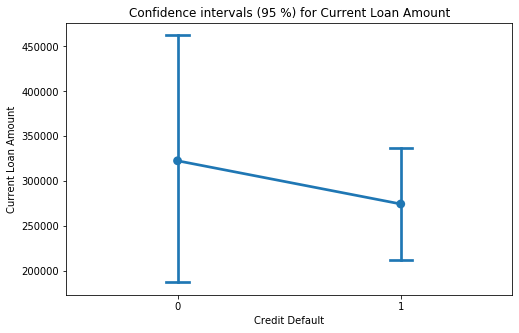

In [61]:
# Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=limit_bal_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Current Loan Amount", hue=TARGET_NAME, data=df_train)
plt.title('Current Loan Amount grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

### Анализ признакового пространства

**Матрица корреляций**

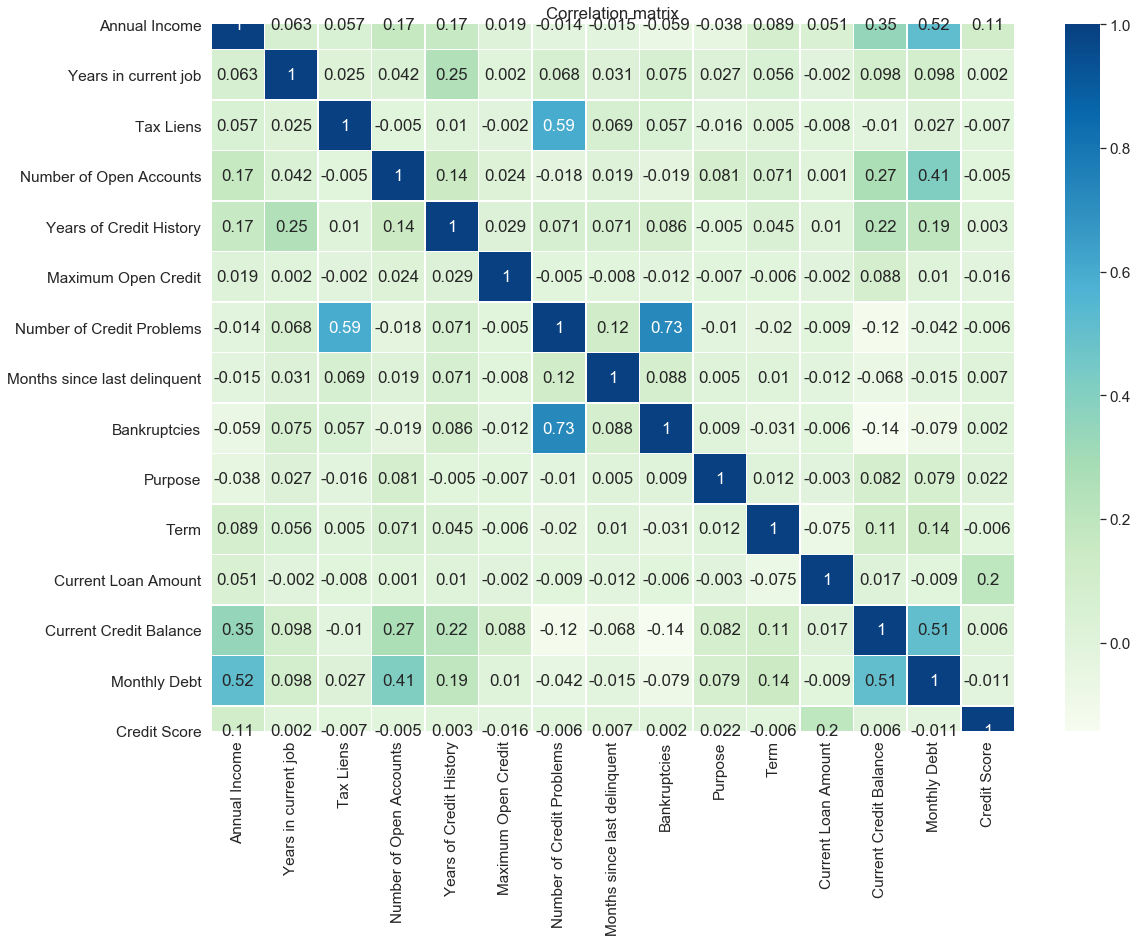

In [62]:
plt.figure(figsize = (18,13))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

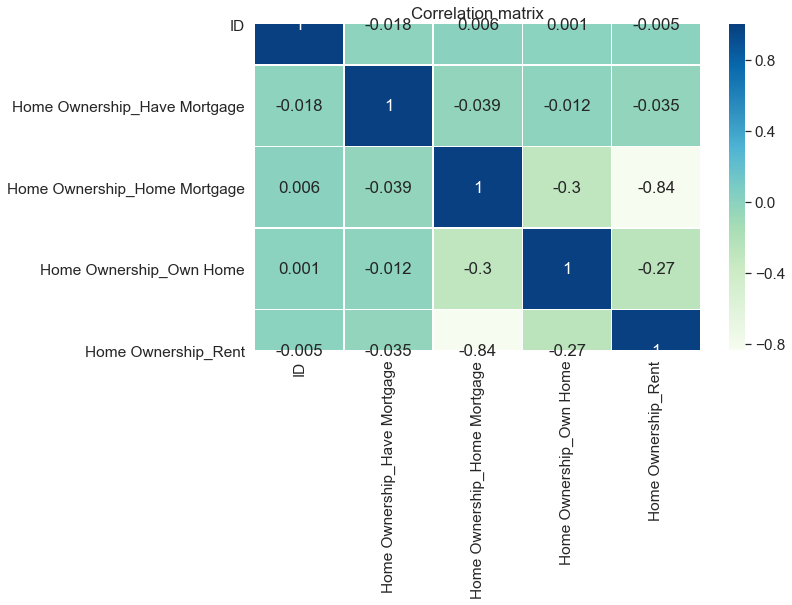

In [66]:
plt.figure(figsize = (10, 6))

sns.set(font_scale=1.4)
sns.heatmap(df_train[NEW_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## Построение модели классификации

### Загрузка данных

In [90]:
df_base = pd.read_csv(TRAIN_DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent
0,Own Home,482087,10,0,11,26,685960,1,14,1,...,99999999,47386,7914,749,0,0,0,0,1,0
1,Own Home,1025487,10,0,15,15,1181730,0,14,0,...,264968,394972,18373,737,1,1,0,0,1,0
2,Home Mortgage,751412,8,0,11,35,1182434,0,14,0,...,99999999,308389,13651,742,0,2,0,1,0,0
3,Own Home,805068,6,0,8,22,147400,1,14,1,...,121396,95855,11338,694,0,3,0,0,1,0
4,Rent,776264,8,0,13,13,385836,1,14,0,...,125840,93309,7180,719,0,4,0,0,0,1


**Выделение целевой переменной и групп признаков**

In [93]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()

### Отбор признаков

In [94]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [95]:
NUM_FEATURE_NAMES = df_base.select_dtypes(include='float64').columns.tolist()
NUM_FEATURE_NAMES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [96]:
CAT_FEATURE_NAMES = df_base.select_dtypes(include='object').columns.tolist()
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [97]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES
SELECTED_FEATURE_NAMES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent']

### Приведение типов для модели CatBoost

In [98]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

### Нормализация данных

In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

**Сохранение модели для нормализации данных**

In [103]:
import pickle
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test

In [105]:
from sklearn.model_selection import train_test_split
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

In [109]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.values.argmax()
    minor_class_name = target_counts.values.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [110]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [111]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов

In [112]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [115]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

In [45]:
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = df_test['Annual Income'].median()
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_test['Months since last delinquent'].mode()[0]
df_test.loc[df_test['Credit Score'] / 1000 > 1, 'Credit Score'] = df_test['Credit Score'] / 10
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = 0
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = df_test['Bankruptcies'].mode()[0]
replacement(df_test)
df_test.loc[df_test['Purpose'] != 'debt consolidation', 'Purpose'] = 'other'
df_test['Term'] = (df_test['Term'] == 'Long Term').astype(int)
df_test['Purpose'] = (df_test['Purpose'] == 'debt consolidation').astype(int)
df_test['ID'] = df_test.index.tolist()
for cat_colname in df_test.select_dtypes(include='object').columns[:]:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)
for colname in df_test.select_dtypes(include='float64').columns.tolist():
    df_test[colname] = df_test[colname].astype(int)
df_test.info()

### Подбор моделей, получение бейзлана

### Построение и оценка базовых моделей

**Логистическая регрессия**

In [120]:
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      3771
           1       0.56      0.53      0.54      2958

    accuracy                           0.61      6729
   macro avg       0.60      0.60      0.60      6729
weighted avg       0.61      0.61      0.61      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.65      0.71      1616
           1       0.37      0.52      0.43       634

    accuracy                           0.62      2250
   macro avg       0.57      0.59      0.57      2250
weighted avg       0.66      0.62      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1057  559
1                303  331


**k ближайших соседей**

In [121]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      3771
           1       0.74      0.68      0.71      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.75      0.75      6729
weighted avg       0.75      0.75      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1616
           1       0.32      0.37      0.34       634

    accuracy                           0.60      2250
   macro avg       0.53      0.53      0.53      2250
weighted avg       0.62      0.60      0.61      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1126  490
1                402  232


**Бустинговые алгоритмы**

*XGBoost*

In [149]:
# import sys
# !{sys.executable} -m pip install xgboost

In [151]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3771
           1       0.95      0.98      0.96      2958

    accuracy                           0.97      6729
   macro avg       0.97      0.97      0.97      6729
weighted avg       0.97      0.97      0.97      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1616
           1       0.42      0.44      0.43       634

    accuracy                           0.67      2250
   macro avg       0.60      0.60      0.60      2250
weighted avg       0.68      0.67      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1233  383
1                357  277


*LightGBM*

In [152]:
# !{sys.executable} -m pip install lightgbm

     |████████████████████████████████| 686kB 406kB/s eta 0:00:01


In [154]:
import lightgbm as lgbm
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3771
           1       0.89      0.92      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1616
           1       0.41      0.46      0.44       634

    accuracy                           0.66      2250
   macro avg       0.59      0.60      0.60      2250
weighted avg       0.67      0.66      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1197  419
1                341  293


*CatBoost*

In [155]:
!{sys.executable} -m pip install catboost

     |████████████████████████████████| 10.9MB 1.9MB/s eta 0:00:01    |█████▍                          | 1.9MB 443kB/s eta 0:00:21
     |████████████████████████████████| 12.9MB 901kB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11429 sha256=304964e8d652c0400a55a939e5fe5001e5cfeef0c74ca5369759267029c64662
  Stored in directory: /Users/levsolovev/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [156]:
import catboost as catb
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3771
           1       0.86      0.87      0.87      2958

    accuracy                           0.88      6729
   macro avg       0.88      0.88      0.88      6729
weighted avg       0.88      0.88      0.88      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1616
           1       0.43      0.48      0.46       634

    accuracy                           0.67      2250
   macro avg       0.61      0.62      0.61      2250
weighted avg       0.69      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1210  406
1                327  307


### Выбор наилучшей модели, настройка гиперпараметров

In [157]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

**Подбор гиперпараметров**

In [173]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [174]:
from sklearn.model_selection import KFold
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [175]:
from sklearn.model_selection import RandomizedSearchCV

In [177]:
#!time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv)
rs.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f8dc01fb290>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [178]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 5}

In [179]:
rs.best_score_

0.5127234647692737

**Обучение и оценка финальной модели**

In [180]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      3771
           1       0.68      0.68      0.68      2958

    accuracy                           0.72      6729
   macro avg       0.72      0.72      0.72      6729
weighted avg       0.72      0.72      0.72      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.69      0.74      1616
           1       0.42      0.57      0.48       634

    accuracy                           0.66      2250
   macro avg       0.61      0.63      0.61      2250
weighted avg       0.70      0.66      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1121  495
1                275  359
CPU times: user 3.55 s, sys: 508 ms, total: 4.06 s
Wall time: 2.73 s


### Проверка качества, борьба с переобучением

### Интерпретация результатов

## Прогнозирование на тестовом датасете

### Загрузка данных

### Приведение типов

### Обработка выбросов

### Обработка пропусков

### Анализ данных

### Отбор признаков

### Балансировка классов

### Прогноз целевой переменной, используя модель, построенную на обучающем датасете